In [6]:
import os
import random
import torch
import argparse
import torchvision
import numpy as np
from PIL import Image
from torch.nn import functional as F
import logging
import timm
from scipy.ndimage import gaussian_filter
import cv2
import matplotlib.pyplot as plt

In [7]:
import importlib

import torch
import numpy as np
from collections import abc

from functools import partial

import multiprocessing as mp
from threading import Thread
from queue import Queue
from inspect import isfunction
from PIL import Image, ImageDraw, ImageFont
import cv2
from torch.nn import functional as F
import logging
import os


def log_local(images, filenames):
    pixel_mean = [0.485, 0.456, 0.406]
    pixel_std = [0.229, 0.224, 0.225]
    pixel_mean = torch.tensor(pixel_mean).unsqueeze(1).unsqueeze(1)  # 3 x 1 x 1
    pixel_std = torch.tensor(pixel_std).unsqueeze(1).unsqueeze(1)
    root = os.path.join("log_image/")
    name = filenames[-7:-4]
    for k in images:
        image = (images[k].squeeze() * pixel_std + pixel_mean) * 255
        image = image.permute(1, 2, 0).to("cpu").numpy()
        filename = "{}-{}.jpg".format(name, k)
        path = os.path.join(root, filenames[:-7], filename)
        os.makedirs(os.path.split(path)[0], exist_ok=True)
        # Image.fromarray(image).save(path)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        cv2.imwrite(path, image)


def cal_anomaly_map(fs_list, ft_list, out_size=224, amap_mode="mul"):
    if amap_mode == "mul":
        anomaly_map = np.ones([out_size, out_size])
    else:
        anomaly_map = np.zeros([out_size, out_size])
    a_map_list = []
    for i in range(len(ft_list)):
        fs = fs_list[i]
        ft = ft_list[i]
        # fs_norm = F.normalize(fs, p=2)
        # ft_norm = F.normalize(ft, p=2)
        a_map = 1 - F.cosine_similarity(fs, ft)
        a_map = torch.unsqueeze(a_map, dim=1)
        a_map = F.interpolate(a_map, size=out_size, mode="bilinear", align_corners=True)
        a_map = a_map[0, 0, :, :].to("cpu").detach().numpy()
        a_map_list.append(a_map)
        if amap_mode == "mul":
            anomaly_map *= a_map
        else:
            anomaly_map += a_map
    return anomaly_map, a_map_list


def log_txt_as_img(wh, xc, size=10):
    # wh a tuple of (width, height)
    # xc a list of captions to plot
    b = len(xc)
    txts = list()
    for bi in range(b):
        txt = Image.new("RGB", wh, color="white")
        draw = ImageDraw.Draw(txt)
        font = ImageFont.truetype("data/DejaVuSans.ttf", size=size)
        nc = int(40 * (wh[0] / 256))
        lines = "\n".join(
            xc[bi][start : start + nc] for start in range(0, len(xc[bi]), nc)
        )

        try:
            draw.text((0, 0), lines, fill="black", font=font)
        except UnicodeEncodeError:
            print("Cant encode string for logging. Skipping.")

        txt = np.array(txt).transpose(2, 0, 1) / 127.5 - 1.0
        txts.append(txt)
    txts = np.stack(txts)
    txts = torch.tensor(txts)
    return txts


def ismap(x):
    if not isinstance(x, torch.Tensor):
        return False
    return (len(x.shape) == 4) and (x.shape[1] > 3)


def isimage(x):
    if not isinstance(x, torch.Tensor):
        return False
    return (len(x.shape) == 4) and (x.shape[1] == 3 or x.shape[1] == 1)


def exists(x):
    return x is not None


def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d


def mean_flat(tensor):
    """
    https://github.com/openai/guided-diffusion/blob/27c20a8fab9cb472df5d6bdd6c8d11c8f430b924/guided_diffusion/nn.py#L86
    Take the mean over all non-batch dimensions.
    """
    return tensor.mean(dim=list(range(1, len(tensor.shape))))


def count_params(model, verbose=False):
    total_params = sum(p.numel() for p in model.parameters())
    if verbose:
        print(f"{model.__class__.__name__} has {total_params * 1.e-6:.2f} M params.")
    return total_params


def instantiate_from_config(config):
    if not "target" in config:
        if config == "__is_first_stage__":
            return None
        elif config == "__is_unconditional__":
            return None
        raise KeyError("Expected key `target` to instantiate.")
    return get_obj_from_str(config["target"])(**config.get("params", dict()))


def get_obj_from_str(string, reload=False):
    module, cls = string.rsplit(".", 1)
    if reload:
        module_imp = importlib.import_module(module)
        importlib.reload(module_imp)
    return getattr(importlib.import_module(module, package=None), cls)

In [4]:
import glob
import logging
import os

import numpy as np
import copy
import tabulate
import torch
import torch.nn.functional as F
from sklearn import metrics
from sklearn.metrics import auc, average_precision_score, precision_recall_curve
from skimage import measure
import pandas as pd
from numpy import ndarray
from statistics import mean
import numpy as np

np.seterr(divide="ignore", invalid="ignore")


def dump(index, save_dir, outputs):
    filenames = outputs["filename"]
    batch_size = 1
    preds = outputs["pred"].cpu().numpy()  # B x 1 x H x W
    masks = outputs["mask"].cpu().numpy()  # B x 1 x H x W
    # heights = outputs["height"].cpu().numpy()
    # widths = outputs["width"].cpu().numpy()
    clsnames = outputs["clsname"]
    for i in range(batch_size):
        file_dir, filename = os.path.split(filenames[i])
        _, subname = os.path.split(file_dir)
        filename = "{}_{}_{}_{}".format(index, clsnames[i], subname, filename)
        filename, _ = os.path.splitext(filename)
        save_file = os.path.join(save_dir, filename + ".npz")
        np.savez(
            save_file,
            filename=filenames[i],
            pred=preds[i],
            mask=masks[i],
            # height=heights[i],
            # width=widths[i],
            clsname=clsnames[i],
        )


def merge_together(save_dir):
    npz_file_list = glob.glob(os.path.join(save_dir, "*.npz"))
    fileinfos = []
    preds = []
    masks = []
    for npz_file in npz_file_list:
        npz = np.load(npz_file)
        fileinfos.append(
            {
                "filename": str(npz["filename"]),
                # "height": npz["height"],
                # "width": npz["width"],
                "clsname": str(npz["clsname"]),
            }
        )
        preds.append(npz["pred"])
        masks.append(npz["mask"])
    preds = np.concatenate(np.asarray(preds), axis=0)  # N x H x W
    masks = np.concatenate(np.asarray(masks), axis=0)  # N x H x W
    return fileinfos, preds, masks


class Report:
    def __init__(self, heads=None):
        if heads:
            self.heads = list(map(str, heads))
        else:
            self.heads = ()
        self.records = []

    def add_one_record(self, record):
        if self.heads:
            if len(record) != len(self.heads):
                raise ValueError(
                    f"Record's length ({len(record)}) should be equal to head's length ({len(self.heads)})."
                )
        self.records.append(record)

    def __str__(self):
        return tabulate.tabulate(
            self.records,
            self.heads,
            tablefmt="pipe",
            numalign="center",
            stralign="center",
        )


class EvalDataMeta:
    def __init__(self, preds, masks, file_info):
        self.preds = preds  # N x H x W
        self.masks = masks  # N x H x W
        self.file_info = file_info


class EvalImage:
    def __init__(self, data_meta, **kwargs):
        self.preds = self.encode_pred(data_meta.preds, **kwargs)
        self.masks = self.encode_mask(data_meta.masks)
        self.file_info = data_meta.file_info
        self.preds_good = sorted(self.preds[self.masks == 0], reverse=True)
        self.preds_defe = sorted(self.preds[self.masks == 1], reverse=True)
        self.num_good = len(self.preds_good)
        self.num_defe = len(self.preds_defe)
        self.desc_score_indices = np.argsort(self.preds, kind="mergesort")[::-1]
        self.y_score = self.preds[self.desc_score_indices]
        self.y_true = self.masks == 1
        self.y_true = self.y_true[self.desc_score_indices]
        self.y_true2 = self.y_true[self.desc_score_indices]

    @staticmethod
    def encode_pred(preds):
        raise NotImplementedError

    def encode_mask(self, masks):
        N, _, _ = masks.shape
        masks = (masks.reshape(N, -1).sum(axis=1) != 0).astype(np.uint8)  # (N, )
        return masks

    def eval_auc(self):
        fpr, tpr, thresholds = metrics.roc_curve(self.masks, self.preds, pos_label=1)
        auc = metrics.auc(fpr, tpr)
        if auc < 0.5:
            auc = 1 - auc
        return auc


class EvalImageMean(EvalImage):
    @staticmethod
    def encode_pred(preds):
        N, _, _ = preds.shape
        return preds.reshape(N, -1).mean(axis=1)  # (N, )


class EvalImageStd(EvalImage):
    @staticmethod
    def encode_pred(preds):
        N, _, _ = preds.shape
        return preds.reshape(N, -1).std(axis=1)  # (N, )


class EvalImageMax(EvalImage):
    @staticmethod
    def encode_pred(preds):
        N, _, _ = preds.shape
        preds = torch.tensor(preds[:, None, ...])  # N x 1 x H x W
        for i in range(0, 8):
            preds = F.avg_pool2d(preds, 8, stride=1)
        preds = preds.cpu().numpy()  # N x 1 x H x W
        return preds.reshape(N, -1).max(axis=1)  # (N, )


class EvalPerPixelAUC:
    def __init__(self, data_meta):
        self.preds = np.concatenate(
            [pred.flatten() for pred in data_meta.preds], axis=0
        )
        self.masks = np.concatenate(
            [mask.flatten() for mask in data_meta.masks], axis=0
        )
        self.masks[self.masks > 0] = 1

    def eval_auc(self):
        fpr, tpr, thresholds = metrics.roc_curve(self.masks, self.preds, pos_label=1)
        auc = metrics.auc(fpr, tpr)
        if auc < 0.5:
            auc = 1 - auc
        return auc


class EvalPerPixelPRO:
    def __init__(self, data_meta):
        self.preds = data_meta.preds
        self.masks = data_meta.masks
        self.masks[self.masks > 0] = 1

    def eval_auc(self):
        pro = compute_pro(self.masks, self.preds)
        return pro


class EvalPerPixelAP:
    def __init__(self, data_meta):
        self.preds = np.concatenate(
            [pred.flatten() for pred in data_meta.preds], axis=0
        )
        self.masks = np.concatenate(
            [mask.flatten() for mask in data_meta.masks], axis=0
        )
        self.masks[self.masks > 0] = 1

    def eval_auc(self):
        ap = average_precision_score(self.masks, self.preds)
        return ap


class EvalImageAP(EvalImage):
    @staticmethod
    def encode_pred(preds):
        N, _, _ = preds.shape
        preds = torch.tensor(preds[:, None, ...])  # N x 1 x H x W
        for i in range(0, 8):
            preds = F.avg_pool2d(preds, 8, stride=1)
        preds = preds.cpu().numpy()  # N x 1 x H x W
        return preds.reshape(N, -1).max(axis=1)  # (N, )

    def eval_auc(self):
        ap = average_precision_score(self.masks, self.preds)
        return ap


class EvalPerPixelF1:
    def __init__(self, data_meta):
        self.preds = np.concatenate(
            [pred.flatten() for pred in data_meta.preds], axis=0
        )
        self.masks = np.concatenate(
            [mask.flatten() for mask in data_meta.masks], axis=0
        )
        self.masks[self.masks > 0] = 1

    def eval_auc(self):
        precisions, recalls, thresholds = precision_recall_curve(self.masks, self.preds)
        f1_scores = (2 * precisions * recalls) / (precisions + recalls)
        f1_px = np.max(f1_scores[np.isfinite(f1_scores)])
        return f1_px


class EvalImageF1(EvalImage):
    @staticmethod
    def encode_pred(preds):
        N, _, _ = preds.shape
        preds = torch.tensor(preds[:, None, ...])  # N x 1 x H x W
        for i in range(0, 8):
            preds = F.avg_pool2d(preds, 8, stride=1)
        preds = preds.cpu().numpy()  # N x 1 x H x W
        return preds.reshape(N, -1).max(axis=1)  # (N, )

    def eval_auc(self):
        precisions, recalls, thresholds = precision_recall_curve(self.masks, self.preds)
        f1_scores = (2 * precisions * recalls) / (precisions + recalls)
        f1_sp = np.max(f1_scores[np.isfinite(f1_scores)])
        return f1_sp


class EvalPerPixelAUPR:
    def __init__(self, data_meta):
        self.preds = np.concatenate(
            [pred.flatten() for pred in data_meta.preds], axis=0
        )
        self.masks = np.concatenate(
            [mask.flatten() for mask in data_meta.masks], axis=0
        )
        self.masks[self.masks > 0] = 1

    def eval_auc(self):
        pr_auc = compute_aupr(self.preds, self.masks)
        return pr_auc


class EvalImageAUPR(EvalImage):
    @staticmethod
    def encode_pred(preds):
        N, _, _ = preds.shape
        preds = torch.tensor(preds[:, None, ...]) # N x 1 x H x W
        for i in range(0, 8):
            preds = F.avg_pool2d(preds, 8, stride=1)
        preds = F.avg_pool2d(preds, 2, stride=1)
        preds = preds.cpu().numpy()  # N x 1 x H x W
        return preds.reshape(N, -1).max(axis=1)  # (N, )

    def eval_auc(self):
        pr_auc = compute_aupr(self.preds, self.masks)
        return pr_auc


eval_lookup_table = {
    "mean": EvalImageMean,
    "std": EvalImageStd,
    "max": EvalImageMax,
    "pixel": EvalPerPixelAUC,
    "pro": EvalPerPixelPRO,
    "appx": EvalPerPixelAP,
    "apsp": EvalImageAP,
    "f1px": EvalPerPixelF1,
    "f1sp": EvalImageF1,
    "auprpx": EvalPerPixelAUPR,
    "auprsp": EvalImageAUPR,
}


def performances(fileinfos, preds, masks, config):
    ret_metrics = {}
    clsnames = set([fileinfo["clsname"] for fileinfo in fileinfos])
    for clsname in clsnames:
        preds_cls = []
        masks_cls = []
        file_cls = []
        for fileinfo, pred, mask in zip(fileinfos, preds, masks):
            if fileinfo["clsname"] == clsname:
                preds_cls.append(pred[None, ...])
                masks_cls.append(mask[None, ...])
                file_cls.append(fileinfo["filename"])
        preds_cls = np.concatenate(np.asarray(preds_cls), axis=0)  # N x H x W
        masks_cls = np.concatenate(np.asarray(masks_cls), axis=0)  # N x H x W
        data_meta = EvalDataMeta(preds_cls, masks_cls, file_cls)

        # auc
        if config.get("auc", None):
            for metric in config["auc"]:
                evalname = metric["name"]
                kwargs = metric.get("kwargs", {})
                eval_method = eval_lookup_table[evalname](data_meta, **kwargs)
                auc = eval_method.eval_auc()
                ret_metrics["{}_{}_auc".format(clsname, evalname)] = auc

    if config.get("auc", None):
        for metric in config["auc"]:
            evalname = metric["name"]
            evalvalues = [
                ret_metrics["{}_{}_auc".format(clsname, evalname)]
                for clsname in clsnames
            ]
            mean_auc = np.mean(np.array(evalvalues))
            ret_metrics["{}_{}_auc".format("mean", evalname)] = mean_auc

    return ret_metrics


def log_metrics(ret_metrics, config):
    logger = logging.getLogger("global_logger")
    clsnames = set([k.rsplit("_", 2)[0] for k in ret_metrics.keys()])
    clsnames = list(clsnames - set(["mean"])) + ["mean"]

    # auc
    if config.get("auc", None):
        auc_keys = [k for k in ret_metrics.keys() if "auc" in k]
        evalnames = list(set([k.rsplit("_", 2)[1] for k in auc_keys]))
        record = Report(["clsname"] + evalnames)

        for clsname in clsnames:
            clsvalues = [
                ret_metrics["{}_{}_auc".format(clsname, evalname)]
                for evalname in evalnames
            ]
            record.add_one_record([clsname] + clsvalues)

        logger.info(f"\n{record}")


def compute_pro(masks: ndarray, amaps: ndarray, num_th: int = 200):
    """Compute the area under the curve of per-region overlaping (PRO) and 0 to 0.3 FPR
    Args:
        category (str): Category of product
        masks (ndarray): All binary masks in test. masks.shape -> (num_test_data, h, w)
        amaps (ndarray): All anomaly maps in test. amaps.shape -> (num_test_data, h, w)
        num_th (int, optional): Number of thresholds
    """
    assert isinstance(amaps, ndarray), "type(amaps) must be ndarray"
    assert isinstance(masks, ndarray), "type(masks) must be ndarray"
    assert amaps.ndim == 3, "amaps.ndim must be 3 (num_test_data, h, w)"
    assert masks.ndim == 3, "masks.ndim must be 3 (num_test_data, h, w)"
    assert amaps.shape == masks.shape, "amaps.shape and masks.shape must be same"
    assert set(masks.flatten()) == {0, 1}, "set(masks.flatten()) must be {0, 1}"
    assert isinstance(num_th, int), "type(num_th) must be int"
    df = pd.DataFrame([], columns=["pro", "fpr", "threshold"])
    binary_amaps = np.zeros_like(amaps, dtype=np.bool_)
    min_th = amaps.min()
    max_th = amaps.max()
    delta = (max_th - min_th) / num_th
    for th in np.arange(min_th, max_th, delta):
        binary_amaps[amaps <= th] = 0
        binary_amaps[amaps > th] = 1
        pros = []
        for binary_amap, mask in zip(binary_amaps, masks):
            for region in measure.regionprops(measure.label(mask)):
                axes0_ids = region.coords[:, 0]
                axes1_ids = region.coords[:, 1]
                tp_pixels = binary_amap[axes0_ids, axes1_ids].sum()
                pros.append(tp_pixels / region.area)
        inverse_masks = 1 - masks
        fp_pixels = np.logical_and(inverse_masks, binary_amaps).sum()
        fpr = fp_pixels / inverse_masks.sum()
        df_new = pd.DataFrame([{"pro": mean(pros), "fpr": fpr, "threshold": th}])
        df = pd.concat([df, df_new], ignore_index=True)
        # df = df.append({"pro": mean(pros), "fpr": fpr, "threshold": th}, ignore_index=True)
    # Normalize FPR from 0 ~ 1 to 0 ~ 0.3
    df = df[df["fpr"] < 0.3]
    df["fpr"] = df["fpr"] / df["fpr"].max()
    pro_auc = auc(df["fpr"], df["pro"])
    return pro_auc


def compute_aupr(
    predicted_masks,
    ground_truth_masks,
    include_optimal_threshold_rates=False,
):
    """
    Computes pixel-wise statistics (AUROC, FPR, TPR) for anomaly segmentations
    and ground truth segmentation masks.

    Args:
        predicted_masks: [list of np.arrays or np.array] [NxHxW] Contains
                            generated segmentation masks.
        ground_truth_masks: [list of np.arrays or np.array] [NxHxW] Contains
                            predefined ground truth segmentation masks
    """
    pred_mask = copy.deepcopy(predicted_masks)
    gt_mask = copy.deepcopy(ground_truth_masks)
    num = 200
    out = {}

    if pred_mask is None or gt_mask is None:
        for key in out:
            out[key].append(float("nan"))
    else:
        fprs, tprs = [], []
        precisions, f1s = [], []
        gt_mask = np.array(gt_mask, np.uint8)

        t = gt_mask == 1
        f = ~t
        n_true = t.sum()
        n_false = f.sum()
        th_min = pred_mask.min() - 1e-8
        th_max = pred_mask.max() + 1e-8
        pred_gt = pred_mask[t]
        th_gt_min = pred_gt.min()
        th_gt_max = pred_gt.max()

        """
        Using scikit learn to compute pixel au_roc results in a memory error since it tries to store the NxHxW float score values.
        To avoid this, we compute the tp, fp, tn, fn at equally spaced thresholds in the range between min of predicted 
        scores and maximum of predicted scores
        """
        percents = np.linspace(100, 0, num=num // 2)
        th_gt_per = np.percentile(pred_gt, percents)
        th_unif = np.linspace(th_gt_max, th_gt_min, num=num // 2)
        thresholds = np.concatenate([th_gt_per, th_unif, [th_min, th_max]])
        thresholds = np.flip(np.sort(thresholds))

        if n_true == 0 or n_false == 0:
            raise ValueError(
                "gt_submasks must contains at least one normal and anomaly samples"
            )

        for th in thresholds:
            p = (pred_mask > th).astype(np.uint8)
            p = p == 1
            fp = (p & f).sum()
            tp = (p & t).sum()

            fpr = fp / n_false
            tpr = tp / n_true
            if tp + fp > 0:
                prec = tp / (tp + fp)
            else:
                prec = 1.0
            if prec > 0.0 and tpr > 0.0:
                f1 = (2 * prec * tpr) / (prec + tpr)
            else:
                f1 = 0.0
            fprs.append(fpr)
            tprs.append(tpr)
            precisions.append(prec)

        pr_auc = metrics.auc(tprs, precisions)
        pr_auc = round(pr_auc, 4)

    return pr_auc

In [ ]:
sampled_file = "results/mvtec_hazelnut_I2I_samples_nfe999/recon_iter0.pt"
sampled_dict = torch.load(sampled_file)

recon_imgs = sampled_dict["recon_arr"]
input_imgs = sampled_dict["input_arr"]
clean_imgs = sampled_dict["clean_arr"]
is_normal_arr = sampled_dict["is_normal_arr"]

print(
    f"Sampling complete! Collect recon_imgs={recon_imgs[0].shape}, input_imgs={input_imgs.shape} clean_imgs={clean_imgs.shape}  is_normal_arr={is_normal_arr.shape}"
)

In [ ]:
def un_scale(img):
    img = (img + 1) / 2
    img = img.clamp_(0, 1)
    # img = (img * 255).to(torch.uint8)
    return img

def mask_un_scale(arr):
    arr = arr.clamp_(-1, 1)
    rescale_arr = (arr + 1) / 2
    rescale_arr = torch.round(rescale_arr)
    return rescale_arr

In [ ]:
def encode_pred(preds):
    # print(f"==>> preds.shape: {preds.shape}")
    N, _, _ = preds.shape
    preds = torch.tensor(preds[:, None, ...])  # N x 1 x H x W
    for i in range(0, 8):
        preds = F.avg_pool2d(preds, 8, stride=1)
    preds = preds.cpu().numpy()  # N x 1 x H x W
    # print(f"==>> preds.reshape(N, -1).max(axis=1): {preds.reshape(N, -1)[0].shape}")
    return preds.reshape(N, -1).max(axis=1)

In [ ]:
evl_dir = "./npz_result"

pretrained_model = timm.create_model("resnet50", pretrained=True, features_only=True)
pretrained_model = pretrained_model
pretrained_model.eval()

os.makedirs(evl_dir, exist_ok=True)
input = {}
for idx in range(0, 83):
    pred_img = un_scale(recon_imgs[idx])
    inp_img = un_scale(input_imgs[idx])
    clean_img = mask_un_scale(clean_imgs[idx])
    img_label = is_normal_arr[idx]

    input_img = inp_img.unsqueeze(dim=0)
    # print(f"==>> input_img.shape: {input_img.shape}")
    input_features = pretrained_model(input_img)
    output_img = pred_img.unsqueeze(dim=0)
    # print(f"==>> output_img: {output_img.shape}")
    output_features = pretrained_model(output_img)
    input_features = input_features[1:4]
    output_features = output_features[1:4]

    # Calculate the anomaly score
    anomaly_map, _ = cal_anomaly_map(
        input_features, output_features, input_img.shape[-1], amap_mode="a"
    )
    anomaly_map = gaussian_filter(anomaly_map, sigma=5)
    anomaly_map = torch.from_numpy(anomaly_map)
    anomaly_map_prediction = anomaly_map.unsqueeze(dim=0).unsqueeze(dim=1)
    input["mask"] = clean_img[0].unsqueeze(dim=0).unsqueeze(dim=0)

    root = os.path.join('./log_image/')
    name = "hazelnut"
    filename_feature = "{}-{}-features.jpg".format(name, idx)
    path_feature = os.path.join(root, name, filename_feature)
    pred_feature = anomaly_map_prediction.squeeze().detach().cpu().numpy()
    pred_feature = (pred_feature * 255).astype("uint8")
    pred_feature = Image.fromarray(pred_feature, mode='L')
    pred_feature.save(path_feature)

    # Heatmap
    input["filename"] = "hazelnut"
    input["clsname"] = [0]
    anomaly_map_new = np.round(255 * (anomaly_map - anomaly_map.min()) / (anomaly_map.max() - anomaly_map.min()))
    anomaly_map_new = anomaly_map_new.cpu().numpy().astype(np.uint8)
    heatmap = cv2.applyColorMap(anomaly_map_new, colormap=cv2.COLORMAP_JET)
    pixel_mean = [0.485, 0.456, 0.406]
    pixel_std = [0.229, 0.224, 0.225]
    pixel_mean = torch.tensor(pixel_mean).unsqueeze(1).unsqueeze(1)  # 3 x 1 x 1
    pixel_std = torch.tensor(pixel_std).unsqueeze(1).unsqueeze(1)
    image = (input_img.squeeze() * pixel_std + pixel_mean) * 255
    image = image.permute(1, 2, 0).to('cpu').numpy().astype('uint8')
    image_copy = image.copy()
    out_heat_map = cv2.addWeighted(heatmap, 0.5, image_copy, 0.5, 0, image_copy)
    heatmap_name = f"{name}_{idx}_heatmap.png"
    cv2.imwrite(root + input["filename"] + heatmap_name, out_heat_map)

    plt.imshow(out_heat_map)
    plt.axis("off")
    plt.savefig("hazelnut_heatmap.png", bbox_inches="tight", dpi=150, pad_inches=0.0)
    # plt.show()

    plt.imshow(clean_img[0], cmap='gray')
    plt.axis("off")
    plt.savefig("hazelnut_GT_Mask.png", bbox_inches="tight", dpi=150, pad_inches=0.0)
    # plt.show()

    plt.imshow(input_img.squeeze(0).permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.savefig("hazelnut_input.png", bbox_inches="tight", dpi=150, pad_inches=0.0)
    # plt.show()

    plt.imshow(output_img.squeeze(0).permute(1, 2, 0).cpu())
    plt.axis("off")
    plt.savefig("hazelnut_output.png", bbox_inches="tight", dpi=150, pad_inches=0.0)
    # plt.show()

    input['pred'] = anomaly_map_prediction
    input["output"] = output_img.cpu()
    input["input"] = input_img.cpu()

    output2 = input
    dump(idx,evl_dir, output2)

    break

evl_metrics = {
    "auc": [
        {"name": "max"},
        {"name": "pixel"},
        {"name": "pro"},
        {"name": "appx"},
        {"name": "apsp"},
        {"name": "f1px"},
        {"name": "f1sp"},
    ]
}
# print("Gathering final results ...")
# fileinfos, preds, masks = merge_together(evl_dir)
# ret_metrics = performances(
#     fileinfos, np.round(preds), masks.astype(np.uint8), evl_metrics
# )

In [25]:
fileinfos, preds, masks = merge_together(evl_dir)

In [26]:
ret_metrics = performances(
    fileinfos, preds, masks.astype(np.uint8), evl_metrics
)

In [ ]:
ret_metrics

In [ ]:
def un_scale(img):
    img = (img + 1) / 2
    img = img.clamp_(0, 1)
    # img = (img * 255).to(torch.uint8)
    return img


def mask_un_scale(arr):
    arr = arr.clamp_(-1, 1)
    rescale_arr = (arr + 1) / 2
    rescale_arr = torch.round(rescale_arr)
    return rescale_arr

C:\Users\shilh\AppData\Local\Temp\ipykernel_7916\1914870175.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pixel_mean = torch.tensor(pixel_mean).unsqueeze(1).unsqueeze(1)  # 3 x 1 x 1
C:\Users\shilh\AppData\Local\Temp\ipykernel_7916\1914870175.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pixel_std = torch.tensor(pixel_std).unsqueeze(1).unsqueeze(1)


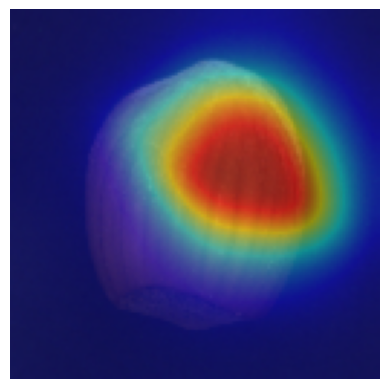

In [8]:
import torch
from PIL import Image
import torchvision.transforms as transforms

pretrained_model = timm.create_model("resnet50", pretrained=True, features_only=True)
pretrained_model = pretrained_model
pretrained_model.eval()

# Read a PIL image
inp_img = Image.open("hazelnut_input.png").convert('RGB').resize((128, 128))
aug_img = Image.open("hazelnut_output.png").convert("RGB").resize((128, 128))
mask_img = Image.open("hazelnut_GT_Mask.png").resize((128, 128))


# Define a transform to convert PIL
# image to a Torch tensor
transform = transforms.Compose([transforms.PILToTensor()])

# transform = transforms.PILToTensor()
# Convert the PIL image to Torch tensor
img_tensor = transform(inp_img)

input = {}
for idx in range(0, 2):
    pred_img = transform(inp_img) / 255
    # print(f"==>> pred_img: {pred_img}")
    inp_img = transform(aug_img) / 255
    # print(f"==>> inp_img: {inp_img}")
    clean_img = transform(mask_img) 
    # print(f"==>> clean_img: {clean_img}")

    input_img = inp_img.unsqueeze(dim=0)
    # print(f"==>> input_img.shape: {input_img.shape}")
    input_features = pretrained_model(input_img)
    output_img = pred_img.unsqueeze(dim=0)
    # print(f"==>> output_img: {output_img.shape}")
    output_features = pretrained_model(output_img)
    input_features = input_features[1:4]
    output_features = output_features[1:4]

    # Calculate the anomaly score
    anomaly_map, _ = cal_anomaly_map(
        input_features, output_features, input_img.shape[-1], amap_mode="a"
    )
    anomaly_map = gaussian_filter(anomaly_map, sigma=5)
    anomaly_map = torch.from_numpy(anomaly_map)
    anomaly_map_prediction = anomaly_map.unsqueeze(dim=0).unsqueeze(dim=1)
    input["mask"] = clean_img[0].unsqueeze(dim=0).unsqueeze(dim=0)

    pred_feature = anomaly_map_prediction.squeeze().detach().cpu().numpy()
    pred_feature = (pred_feature * 255).astype("uint8")
    pred_feature = Image.fromarray(pred_feature, mode="L")

    # Heatmap
    input["filename"] = "hazelnut"
    input["clsname"] = [0]
    anomaly_map_new = np.round(
        255
        * (anomaly_map - anomaly_map.min())
        / (anomaly_map.max() - anomaly_map.min())
    )
    anomaly_map_new = anomaly_map_new.cpu().numpy().astype(np.uint8)
    heatmap = cv2.applyColorMap(anomaly_map_new, colormap=cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    pixel_mean = [0.485, 0.456, 0.406]
    pixel_std = [0.229, 0.224, 0.225]
    pixel_mean = torch.tensor(pixel_mean).unsqueeze(1).unsqueeze(1)  # 3 x 1 x 1
    pixel_std = torch.tensor(pixel_std).unsqueeze(1).unsqueeze(1)
    pixel_mean = torch.tensor(pixel_mean).unsqueeze(1).unsqueeze(1)  # 3 x 1 x 1
    pixel_std = torch.tensor(pixel_std).unsqueeze(1).unsqueeze(1)
    image = (input_img.squeeze() * pixel_std + pixel_mean) * 255
    image = (inp_img.permute(1, 2, 0).to("cpu").numpy() * 255).astype("uint8")
    image_copy = image.copy()

    out_heat_map = (0.5 * image_copy + (1 - 0.5) * heatmap).astype(np.uint8)

    # out_heat_map = cv2.addWeighted(heatmap, 0.5, image_copy, 0.95, 0, image_copy)

    plt.imshow(out_heat_map)
    plt.axis("off")
    plt.savefig("simple_hazelnut_heatmap.png", bbox_inches="tight", dpi=150, pad_inches=0.0)
    # plt.show()

    # plt.imshow(clean_img[0], cmap="gray")
    # plt.axis("off")
    # plt.savefig("hazelnut_GT_Mask.png", bbox_inches="tight", dpi=150, pad_inches=0.0)
    # # plt.show()

    # plt.imshow(input_img.squeeze(0).permute(1, 2, 0).cpu())
    # plt.axis("off")
    # plt.savefig("hazelnut_input.png", bbox_inches="tight", dpi=150, pad_inches=0.0)
    # # plt.show()

    # plt.imshow(output_img.squeeze(0).permute(1, 2, 0).cpu())
    # plt.axis("off")
    # plt.savefig("hazelnut_output.png", bbox_inches="tight", dpi=150, pad_inches=0.0)
    # # plt.show()

    break

In [9]:
from PIL import Image

im = Image.open("simple_hazelnut_heatmap.png")

# Flip image
out = im.transpose(Image.FLIP_LEFT_RIGHT)

out.save("rev-simple_hazelnut_heatmap.png")
